# BLM calculator

Steps in this pipeline:
1. Run the same scenario 6 times, 10 runs each, modifying the BLM value according to: 
BLM = Z*sqrt(PU area)
(Z = 0.001, 0.01, 0.1,1, 10 and 100)  
(Helper functions to run Marxan are at the bottom)

2. Spatial plot the best solution of each of these scenario outputs (Visually inspect changes in BLM)
3. Plot Boundary Length vs Cost (Curve)
4. Calculate the optimum BLM value that minimizes both cost and Boundary length (clumping)

*The planning units grid shapefile is requiered for the Boundary length calculation

In [9]:
# to bring all functions that we have develop for marxan.
%run marxan_utils.ipynb

## 1. Estimate BLM testing values (6 scenarios keeping all inputs equal except BLM)

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from shutil import copyfile
from distutils.dir_util import copy_tree
import kneed

In [3]:
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_Targets'

In [4]:
### PU Area
pu_area = gpd.read_file(f'{MARXAN_FOLDER}/pu/pulayer.shp')
#pu_area.crs

In [5]:
 def create_blmProject(path: str) -> list:
    MARXAN_INPUTDATA = 'input.dat'
    #copy_tree(f'{path}', f'{path}/blm')
    # BLM values to start calibration
    # Rule of thumb: Z = pu_area*[0.01,0.1,1,10,100]
    ### RUN MARXAN 6 times
    blm_range= [0.001,0.01,0.1,1,10,100]
    area = pu_area['geometry'].map(lambda p: p.area / 10**6).mean()
    blm_values = [element * math.sqrt(area) for element in blm_range]
    blm_dict = dict(zip(blm_range, blm_values))
    
    blm_folder=[]
    InputFile = DatFile(f'{path}/{MARXAN_INPUTDATA}')
    InputFile.read()

    for blm in blm_values:
        print(f'BLM_{blm}')
        userInputFile = inputDatFile.from_dat(InputFile.data)

        ## Modify for BLM calculations and save as new input.dat
        userInputFile.BLM = blm
        userInputFile.OUTPUTDIR =f'BLM_{blm}'
        userInputFile.NUMREPS =10

        userInputFile_df = pd.DataFrame.from_dict(userInputFile.__dict__, orient='index')
        userInputFile_df.drop('BLOCKDEFNAME', inplace=True)

        CreateFileFromDF(f'{path}/{MARXAN_INPUTDATA}',userInputFile_df, inputDatFile)
        if not os.path.exists(f'{path}/{userInputFile.OUTPUTDIR}'):
            os.mkdir(f'{path}/{userInputFile.OUTPUTDIR}')

        blm_folder.append(f'{userInputFile.OUTPUTDIR}')
        execute_marxan(path)
        
    ## 3. Create a plot from the best solution of each BLM scenario    
    #fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
    fig = plt.figure(figsize=(10,10))

    for idx, blm in enumerate(blm_folder):
        axn = fig.add_subplot(321+idx)
        solution = pd.read_csv(f"{MARXAN_FOLDER}/{blm}/output_best.csv")
        solution_grid = pu_area.merge(solution,left_on='PUID',right_on = 'PUID',how='inner')
        solution_grid.plot(ax=axn,column='SOLUTION', legend=True)
        axn.set_title(f'{blm}')
    
    return blm_folder, blm_values
 
    

## 4. Calculate optimum BLM

- For each BLM scenario infer best solution from lowest score  
- For each BLM scenario calculate Boundary Length of the best solution
- Create df with values for best solution of each BLM scenario 
- Find the point of max curvature to establish as optimum BLM with [kneed](https://www.kaggle.com/kevinarvai/knee-elbow-point-detection) package

In [6]:
def BLM_calibration(path: str, Plot: bool = True)-> float:
    blm_df =pd.DataFrame(columns=['folder','blm'])
    blm_folder, blm_values = create_blmProject(MARXAN_FOLDER)
    blm_df['folder'] = blm_folder
    blm_df['blm']= blm_values

    for blm in blm_folder:
        summary = pd.read_csv(f"{path}/{blm}/output_sum.csv")
        best =summary.loc[summary.loc[:]['Score'].idxmin(),'Run_Number']
        cost=summary.loc[best-1,'Cost']
        blm_df.loc[blm_df['folder']==blm,'cost']=cost
    
        solution = pd.read_csv(f"{path}/{blm}/output_best.csv")
        solution_grid = pu_area.merge(solution,left_on='PUID',right_on = 'PUID',how='inner')
        blm_df.loc[blm_df['folder']==blm,'boundary_length']=solution_grid.dissolve(by='SOLUTION')['geometry'].length[1] ## perimeter in m
    
    y = blm_df['boundary_length']
    x = blm_df['cost']
    kn = kneed.KneeLocator(x, y, curve='convex', direction='decreasing')
    best_blm = blm_df.loc[blm_df['cost']==kn.knee,'blm'].values[0]
    #blm_df.loc[blm_df['cost']==kn.knee,'folder'].values[0] #in which folder

    print(f'The optimun BLM is {best_blm}')
    fig = plt.figure(figsize=(10,10))
    if Plot==True:
        plt.xlabel('cost')
        plt.ylabel('boundary length')
        plt.plot(x, y, 'bx-')
        plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
        
    return best_blm

BLM_0.002
Marxan v 2.43

Marine Reserve Design via Annealing

Coded by Ian Ball, modified by Matthew Watts
Written by Ian Ball and Hugh Possingham

ian.ball@aad.gov.au
h.possingham@uq.edu.au
m.watts@uq.edu.au

Marxan website

http://www.uq.edu.au/marxan

WARNING variable: CLUMPTYPE appears more than once in the input file. Final value taken

Entering in the data files
There are 12178 Planning units.
12178 Planning Unit names read in
59 species read in
25108 connections entered
36859 conservation values counted, 718502 big matrix size, 5.12998% density of matrix
Time passed so far is 0 secs

Pre-processing Section.

Run 1   Using Calculated Tinit = 1616.0000 Tcool = 0.99945893
Creating the initial reserve

Init:Value 3477552.0 Cost 3424716.0 PUs 6086 Connection 26112000.0 Missing 1 Shortfall 422000.00 Penalty 612.0 MPM 0.8

ThermalAnnealing:Value 1360827.6 Cost 1330796.0 PUs 3197 Connection 14560000.0 Missing 1 Shortfall 2594000.00 Penalty 911.6 MPM 0.9

Iterative Improvement:Value 1360

0.2

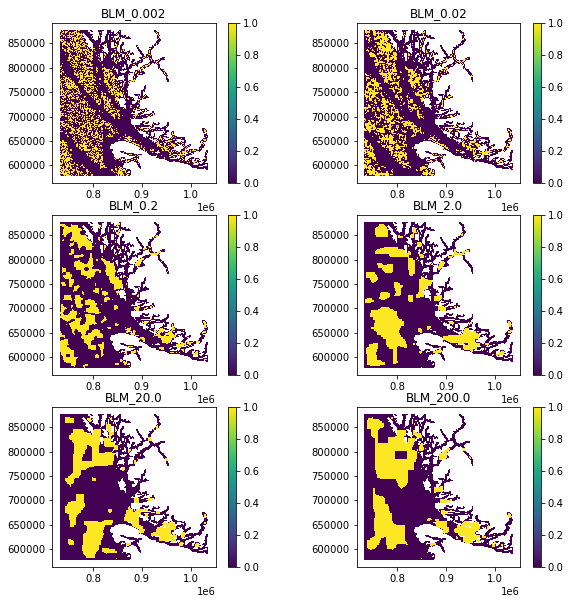

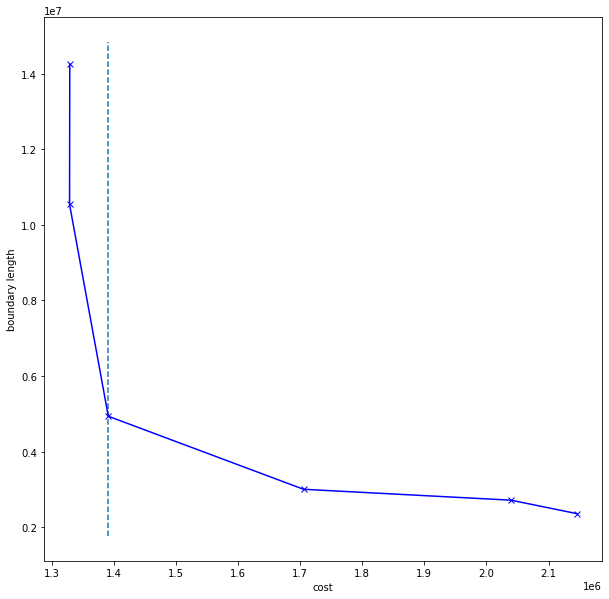

In [7]:
BLM_calibration(MARXAN_FOLDER)